# GDSFactory Euler bend

The same euler bend can also be coded in [GDSFactory](https://github.com/gdsfactory/gdsfactory). GDSFactory has better integration with Lumerical, allowing us to easily automate S-matrix sweeps. We can do this to quantify the loss in the bend:

In [1]:
import pp
import lumapi
import numpy as np
from scipy.special import fresnel

Let's define an Euler bend:

In [7]:
def _euler_bend_center_line_shape(R=10, theta=np.pi/2, num_points=1000):
    """
    Args:
        R (float): minimal bend radius
        theta (float): final angle (in radians)
        num_points (int): resolution of the shape
    """
    L = R * theta  # HALF of total length
    s = np.linspace(0, L, num_points // 2)
    f = np.sqrt(np.pi * R * L) + 1e-18  # for numerical stability
    y1, x1 = fresnel(s / f)
    # first, rotate by the final angle
    x2, y2 = np.dot(
        np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]]),
        np.stack([x1, y1], 0),
    )
    # then, flip along the x-axis (and reverse direction of the curve):
    x2, y2 = -x2[::-1], y2[::-1]
    # then translate from (x2[0], y2[0]) to (x1[-1], y1[-1])
    x2, y2 = x2 - x2[0] + x1[-1], y2 - y2[0] + y1[-1]
    x = f * np.concatenate([x1, x2], 0)
    y = f * np.concatenate([y1, y2], 0)
    return np.stack([x,y], 1)

@pp.autoname
def euler_bend(R=10, theta=90, width=1.0, num_points=300, layer=(1,0)):
    """
    Args:
        R (float): minimal bend radius (at middle of bend)
        theta (float): final angle (in degrees)
        num_points (int): resolution of the shape
        layer (tuple): waveguide layer
    """
    c = pp.Component()
    theta *= np.pi/180
    center_line = _euler_bend_center_line_shape(R=R, theta=theta, num_points=num_points)
    polygon = pp.geo_utils.extrude_path(
        points=center_line,
        width=width,
    )
    c.add_polygon(polygon, layer=layer)
    c.info["length"] = 2 * R * theta
    c.radius = c.R = R
    c.add_port(
        name="in0",
        midpoint=np.round(center_line[0], 3),
        orientation=180,
        layer=layer,
        width=width,
    )
    c.add_port(
        name="out0",
        midpoint=np.round(center_line[-1], 3),
        orientation=theta*180/np.pi,
        layer=layer,
        width=width,
    )
    return pp.port.auto_rename_ports(c)

Let's show the bend:

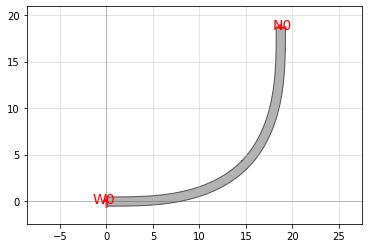

In [6]:
c = euler_bend(theta=90, width=1.0, R=10)
pp.qp(c)

we can calculate the S-matrices of the bend as follows:

In [8]:
R = np.array([1, 1.25, 1.5, 1.75, 2, 2.5, 3, 6, 9, 12, 16, 20])
T = np.zeros((R.shape[0], 500))
for i, r in enumerate(R):
    c = euler_bend(R=r, theta=90, width=1.0)
    S = pp.sp.write(c, run=True, mesh_accuracy=1, wavelength_start=1.5e-6, wavelength_stop=1.6e-6, wavelength_points=500, overwrite=False)
    wl = np.array(S['wavelength_nm'])
    T[i] = np.array(S['S12m'])

internally, `pp.sp.write` will use the Lumerical Python API to calculate the S-parameters. We are interested in the *magnitude* of the $S_{12}$ element, i.e. `'S12m'`, which will give the transmission of the bend:

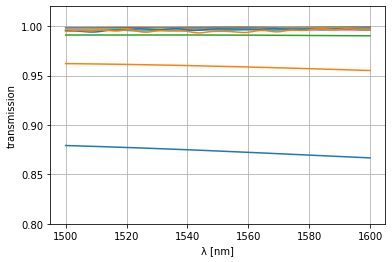

In [17]:
plt.plot(wl, T.T)
plt.xlabel("λ [nm]")
plt.ylabel("transmission")
plt.grid()
plt.ylim(0.8, 1.02)
plt.yticks([0.8,0.85,0.9,0.95,1])
plt.show()

We clearly see that below a minimum bend radius of 2.5, the transmission rapidly degrades:

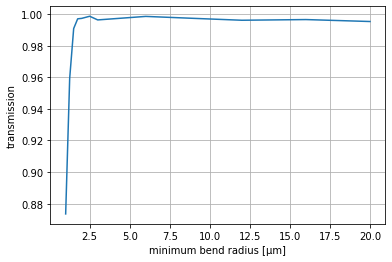

In [19]:
plt.plot(R, T.mean(1))
plt.grid()
plt.xlabel("minimum bend radius [μm]")
plt.ylabel("transmission")
plt.show()

Note that the S-parameters were found with a Lumerical FDTD simulation with `mesh_accuracy=1`: the lowest accuracy. To obtain more accurate results, these simulations should be done with higher accuracy (or a different technique, like mode solvers should be used).